# Setup

In [148]:
# Set the folders containing annotated data
lineage_folder = "data/ablation-lineage/"
czi_folder = "data/ablation-czi/"

# Load data

## Parse lineage files

In [149]:
import os
import glob
import pandas as pd

# Set the folder containing .lineage files
pattern = os.path.join(lineage_folder, "*.lineage")
files = sorted(glob.glob(pattern))

if not files:
    raise FileNotFoundError(f"No .lineage files found in {lineage_folder!r}")

out_rows = []
point_id_counter = 0

for p in files:
    cell_id = os.path.splitext(os.path.basename(p))[0]
    try:
        df = pd.read_csv(p, sep="\t", comment="#", engine="python")
    except Exception as e:
        print(f"Warning: failed to read {p!r}: {e}")
        continue
    required = {"cell", "time", "x", "y"}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        print(f"Warning: skipping {p!r}: missing columns {', '.join(sorted(missing))}")
        continue
    # Drop file if any "flow" entry is present
    if df["cell"].str.contains("flow", case=False, na=False).any():
        print(f"Warning: skipping {p!r}: contains 'flow' entry")
        continue
    valid_mask = df["cell"].str.startswith("New nucleus") | df["cell"].str.startswith("cut")
    df = df[valid_mask].copy()
    if df.empty:
        print(f"Warning: skipping {p!r}: no valid points found")
        continue
    result = df[["cell", "time", "x", "y"]].copy()
    result["frame"] = result["time"].copy()
    result["cut"] = result["cell"].apply(lambda x: x.startswith("cut"))
    result["cell_id"] = cell_id
    cell_names = result["cell"].unique()
    cell_to_point_id = {name: point_id_counter + i for i, name in enumerate(cell_names)}
    result["point_id"] = result["cell"].map(cell_to_point_id)
    result = result.drop(columns=["cell"])
    point_id_counter += len(cell_names)
    out_rows.append(result)

if not out_rows:
    raise ValueError("No valid data parsed from .lineage files.")

print(f"Parsed data for {point_id_counter} unique points from {len(out_rows)} files.")

points = pd.concat(out_rows, ignore_index=True)
points = points[["point_id", "cell_id", "cut", "frame", "x", "y"]]

points.head()

Parsed data for 1912 unique points from 175 files.


,point_id,cell_id,cut,frame,x,y
0,0,220530-E1_Out,False,3,368.0,192.0
1,1,220530-E1_Out,False,3,306.0,251.0
2,2,220530-E1_Out,False,3,374.0,224.0
3,3,220530-E1_Out,False,3,323.0,202.0
4,4,220530-E1_Out,False,3,325.0,218.0


## Parse czi files

In [150]:
import os
import numpy as np
import czifile as cz
import xml.etree.ElementTree as ET

df = points.copy()

# Get unique cell_ids
cell_ids =df['cell_id'].unique()

processed_groups = []
for cell_id in cell_ids:
    cell_mask = df['cell_id'] == cell_id
    cell_df = df[cell_mask].copy()
    czi_filename = f"{cell_id}.czi"
    czi_path = os.path.join(czi_folder, czi_filename)

    if not os.path.exists(czi_path):
        print(f"Warning: CZI file not found for cell_id {cell_id!r} (expected {czi_filename})")
        cell_df['timestamp'] = np.nan
        processed_groups.append(cell_df)
        continue

    # Open the CZI file once
    with cz.CziFile(czi_path) as czi:
        # 1. Extract timestamps
        timestamps = None
        for attachment in czi.attachments():
            if attachment.attachment_entry.name == 'TimeStamps':
                timestamps = attachment.data()
                break

        if timestamps is None:
            print(f"Warning: No timestamps found in {czi_path}")
            cell_df['timestamp'] = np.nan
        else:
            frames = cell_df["frame"].values
            frames = np.clip(frames, 0, len(timestamps) - 1)
            cell_df['timestamp'] = timestamps[frames]

        # 2. Extract pixel scaling
        xml_metadata = czi.metadata()
        root = ET.fromstring(xml_metadata)
        scaling_x = root.find('.//{*}Scaling/{*}Items/{*}Distance[@Id="X"]/{*}Value')
        scaling_y = root.find('.//{*}Scaling/{*}Items/{*}Distance[@Id="Y"]/{*}Value')

        pixel_x = float(scaling_x.text) * 1e6 if scaling_x is not None else None
        pixel_y = float(scaling_y.text) * 1e6 if scaling_y is not None else None

    # Convert coordinates
    if pixel_x is not None and pixel_y is not None:
        cell_df['x_pixel_size'] = pixel_x
        cell_df['y_pixel_size'] = pixel_y
    else:
        print(f"Warning: Pixel size information not found for {czi_path}.")

    processed_groups.append(cell_df)

# Concatenate all processed groups
points_irl = pd.concat(processed_groups, ignore_index=True)

# points_irl now contains the mapped timestamps and coordinates in micrometers
points_irl.head()


,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355
1,1,220530-E1_Out,False,3,306.0,251.0,2731.228878,0.050355,0.050355
2,2,220530-E1_Out,False,3,374.0,224.0,2731.228878,0.050355,0.050355
3,3,220530-E1_Out,False,3,323.0,202.0,2731.228878,0.050355,0.050355
4,4,220530-E1_Out,False,3,325.0,218.0,2731.228878,0.050355,0.050355


# Calculate frame relative to cut

In [151]:
# Calculate frame relative to cut (0 is cut time, -1 is one frame before cut, etc.)
df = points_irl.copy()

df['cut_time'] = df.groupby('cell_id').apply(lambda group: group.loc[group['cut'], 'frame'].min()).reindex(df['cell_id']).values
df['frame_rel'] = df['frame'] - df['cut_time']

points_rel = df.copy()
points_rel.head()

/tmp/ipykernel_119927/3530966781.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cut_time'] = df.groupby('cell_id').apply(lambda group: group.loc[group['cut'], 'frame'].min()).reindex(df['cell_id']).values


,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,cut_time,frame_rel
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,4,-1
1,1,220530-E1_Out,False,3,306.0,251.0,2731.228878,0.050355,0.050355,4,-1
2,2,220530-E1_Out,False,3,374.0,224.0,2731.228878,0.050355,0.050355,4,-1
3,3,220530-E1_Out,False,3,323.0,202.0,2731.228878,0.050355,0.050355,4,-1
4,4,220530-E1_Out,False,3,325.0,218.0,2731.228878,0.050355,0.050355,4,-1


# Calculate coordinates relative to cut

In [152]:
# Calculate cut-based coordinates (x_parallel, x_perpendicular, cut_length) with cut1 as the cut with lowest y value
import numpy as np

df = points_rel.copy()

for cell_id in df["cell_id"].unique():
    cell_mask = df["cell_id"] == cell_id
    cell_df = df[cell_mask]
    cut_points = cell_df[cell_df["cut"] == True]
    if len(cut_points) > 2:
        print(f"Warning: cell_id {cell_id!r} has more than 2 cut points; skipping cut coordinate calculation.")
        continue
    if len(cut_points) < 2:
        print(f"Warning: cell_id {cell_id!r} has less than 2 cut points; skipping cut coordinate calculation.")
        continue

    # Sort cut points so cut1 is the one with lowest y value
    cut_points_sorted = cut_points.sort_values("y", ascending=False)
    cut1 = cut_points_sorted.iloc[0]
    cut2 = cut_points_sorted.iloc[1]

    cut_vector = np.array([cut2["x"] - cut1["x"], cut2["y"] - cut1["y"]])
    cut_length = np.linalg.norm(cut_vector)

    if cut_length == 0:
        print(f"Warning: cell_id {cell_id!r} has identical cut points; skipping cut coordinate calculation.")
        continue

    cut_unit = cut_vector / cut_length
    perp_unit = np.array([-cut_unit[1], cut_unit[0]])
    origin = np.array([cut1["x"], cut1["y"]])

    for idx in cell_df.index:
        point = np.array([df.loc[idx, "x"], df.loc[idx, "y"]])
        relative_pos = point - origin
        df.loc[idx, "x_parallel"] = np.dot(relative_pos, cut_unit) / cut_length
        df.loc[idx, "x_perpendicular"] = np.dot(relative_pos, perp_unit)
        df.loc[idx, "cut_length"] = cut_length

# Remove points that are not within cut length
df = df[(df['x_parallel'] >= 0) & (df['x_parallel'] <= 1)]

points_cut = df.copy()
points_cut.head()

,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,4,-1,0.781787,28.094557,93.434469
1,1,220530-E1_Out,False,3,306.0,251.0,2731.228878,0.050355,0.050355,4,-1,0.089347,-27.934017,93.434469
2,2,220530-E1_Out,False,3,374.0,224.0,2731.228878,0.050355,0.050355,4,-1,0.447079,37.149031,93.434469
3,3,220530-E1_Out,False,3,323.0,202.0,2731.228878,0.050355,0.050355,4,-1,0.628866,-15.732952,93.434469
4,4,220530-E1_Out,False,3,325.0,218.0,2731.228878,0.050355,0.050355,4,-1,0.460481,-12.201065,93.434469


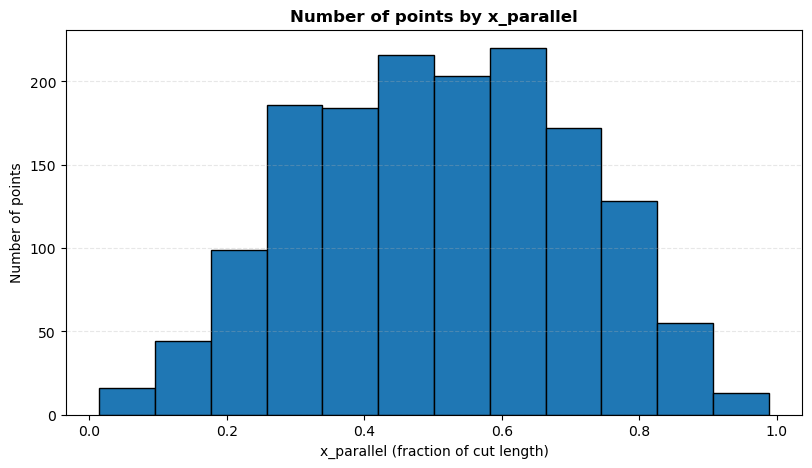

In [153]:
import benchmark.utils as bu

bu.plot_points_by_x_parallel(points_cut, 12)

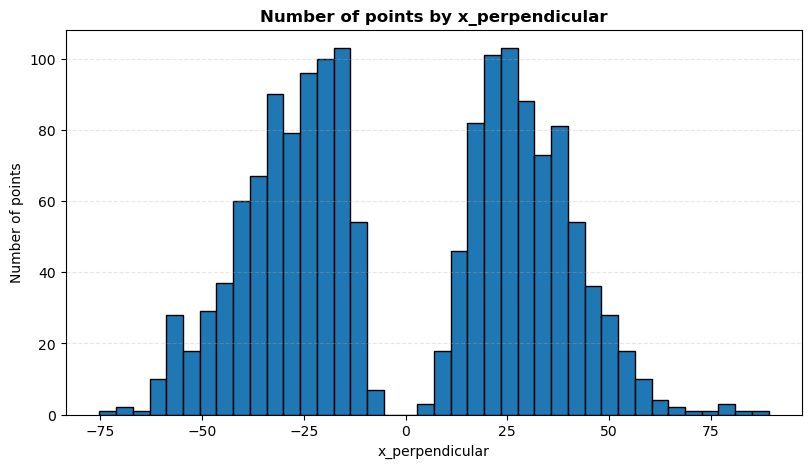

In [154]:
bu.plot_points_by_x_perpendicular(points_cut, False, 40)

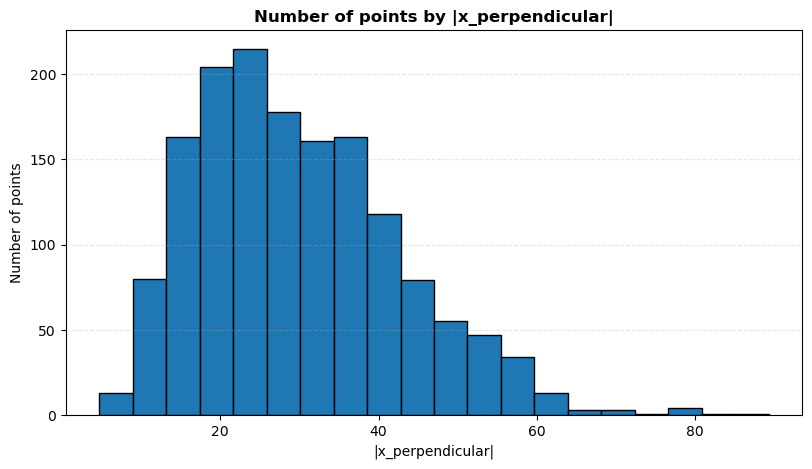

In [155]:
bu.plot_points_by_x_perpendicular(points_cut, True, 20)

In [156]:
bu.animate_points_by_x_perpendicular(points_cut, False)

In [157]:
bu.animate_points_by_x_perpendicular(points_cut, True)

# Calculate time relative to first tracked point per cell and point velocities

In [158]:
import numpy as np

df = points_cut.copy()

# Compute velocity using frame as time reference, store on starting point
df = df.sort_values(["point_id", "frame"]).reset_index(drop=True)
df["dx"] = df.groupby("point_id")["x"].shift(-1) - df["x"]
df["dy"] = df.groupby("point_id")["y"].shift(-1) - df["y"]
df["dt"] = df.groupby("point_id")["frame"].shift(-1) - df["frame"]
df["vx"] = np.where(df["dt"] > 0, df["dx"] / df["dt"], np.nan)
df["vy"] = np.where(df["dt"] > 0, df["dy"] / df["dt"], np.nan)
df["velocity"] = np.sqrt(df["vx"]**2 + df["vy"]**2)

# Clean up intermediate columns
df = df.drop(columns=["dx", "dy"])

# Calculate cut velocities using frame as time reference, store on starting point
df["dx_parallel"] = df.groupby("point_id")["x_parallel"].shift(-1) - df["x_parallel"]
df["dx_perpendicular"] = df.groupby("point_id")["x_perpendicular"].shift(-1) - df["x_perpendicular"]
df["dt"] = df.groupby("point_id")["frame"].shift(-1) - df["frame"]
df["v_parallel"] = np.where(df["dt"] > 0, df["dx_parallel"] / df["dt"], np.nan)
df["v_perpendicular"] = np.where(df["dt"] > 0, df["dx_perpendicular"] / df["dt"], np.nan)
df["velocity_cut"] = np.sqrt(df["v_parallel"]**2 + df["v_perpendicular"]**2)

# Clean up intermediate columns
df = df.drop(columns=["dx_parallel", "dx_perpendicular", "dt"])

points_v = df.copy()

points_v.head()


,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,4,-1,0.781787,28.094557,93.434469,3.0,0.0,3.000000,0.003093,2.986050,2.986052
1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,4,0,0.784880,31.080607,93.434469,1.0,1.0,1.414214,-0.009622,1.091674,1.091717
2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,4,1,0.775258,32.172281,93.434469,2.0,1.0,2.236068,-0.008591,2.087024,2.087042
3,0,220530-E1_Out,False,6,374.0,194.0,2736.011395,0.050355,0.050355,4,2,0.766667,34.259305,93.434469,1.0,0.0,1.000000,0.001031,0.995350,0.995351
4,0,220530-E1_Out,False,7,375.0,194.0,2737.007224,0.050355,0.050355,4,3,0.767698,35.254655,93.434469,0.0,-1.0,1.000000,0.010653,-0.096324,0.096911


# Remove points with unrealistic velocities

In [159]:
df = points_v.copy() 

filter_threshold = 11  # Velocity threshold

initial_count = df['point_id'].nunique()

to_remove = []
for pid in df['point_id'].unique():
    vals = df.loc[df['point_id'] == pid, 'velocity_cut']
    if vals.dropna().empty:
        continue
    if (vals.abs() > filter_threshold).any():
        to_remove.append(pid)

if to_remove:
    df = df[~df['point_id'].isin(to_remove)]

final_count = df['point_id'].nunique()
diff_count = initial_count - final_count

print(f"Total filtered out: {diff_count} point{"s" if diff_count != 1 else ""} based on velocity threshold {filter_threshold}")

points_v_filtered = df.copy()

points_v_filtered.head()

Total filtered out: 60 points based on velocity threshold 11


,point_id,cell_id,cut,frame,x,y,timestamp,x_pixel_size,y_pixel_size,cut_time,frame_rel,x_parallel,x_perpendicular,cut_length,vx,vy,velocity,v_parallel,v_perpendicular,velocity_cut
0,0,220530-E1_Out,False,3,368.0,192.0,2731.228878,0.050355,0.050355,4,-1,0.781787,28.094557,93.434469,3.0,0.0,3.000000,0.003093,2.986050,2.986052
1,0,220530-E1_Out,False,4,371.0,192.0,2734.003849,0.050355,0.050355,4,0,0.784880,31.080607,93.434469,1.0,1.0,1.414214,-0.009622,1.091674,1.091717
2,0,220530-E1_Out,False,5,372.0,193.0,2734.999678,0.050355,0.050355,4,1,0.775258,32.172281,93.434469,2.0,1.0,2.236068,-0.008591,2.087024,2.087042
3,0,220530-E1_Out,False,6,374.0,194.0,2736.011395,0.050355,0.050355,4,2,0.766667,34.259305,93.434469,1.0,0.0,1.000000,0.001031,0.995350,0.995351
4,0,220530-E1_Out,False,7,375.0,194.0,2737.007224,0.050355,0.050355,4,3,0.767698,35.254655,93.434469,0.0,-1.0,1.000000,0.010653,-0.096324,0.096911


# Remove points more than 1 frame before the cut

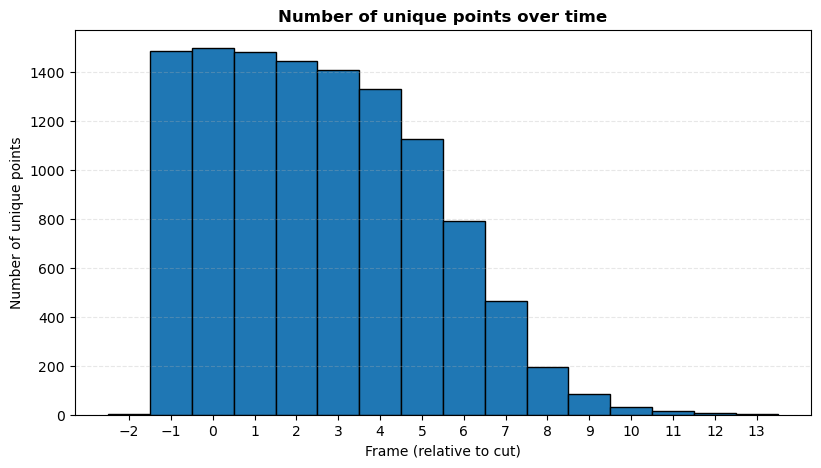

In [160]:
bu.plot_points_by_frame(points_v_filtered[points_v_filtered['cut'] == False])

In [161]:
points_final = points_v_filtered[points_v_filtered['frame_rel'] >= -1][points_v_filtered['frame_rel'] <= 8].copy()

/tmp/ipykernel_119927/3989170144.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  points_final = points_v_filtered[points_v_filtered['frame_rel'] >= -1][points_v_filtered['frame_rel'] <= 8].copy()


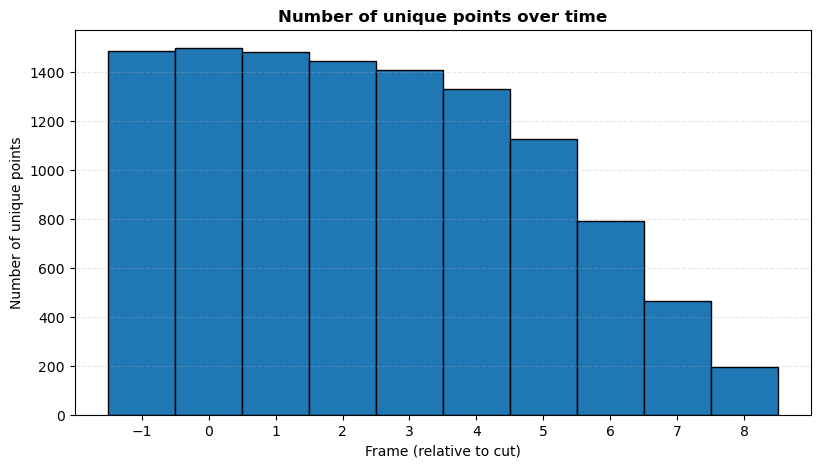

In [162]:
bu.plot_points_by_frame(points_final[points_final['cut'] == False])

# Output csv file

In [163]:
points_final.to_csv('out/points.csv')

# Velocity analysis

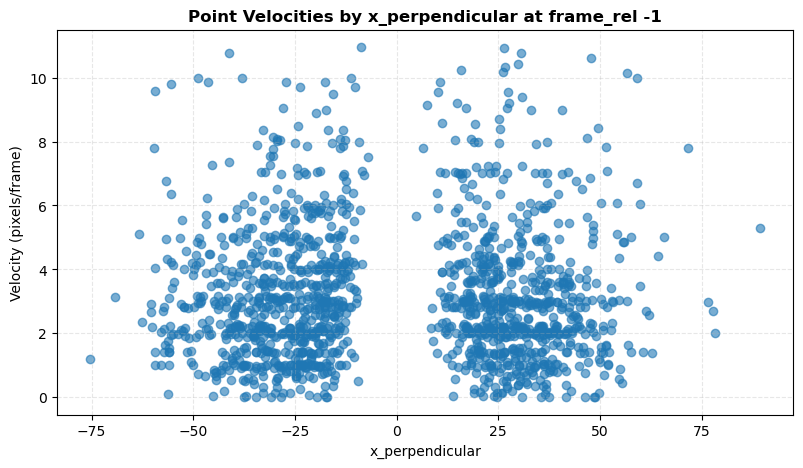

In [164]:
bu.plot_velocities_by_x_perpendicular(points_final, False, frame_rel=-1)

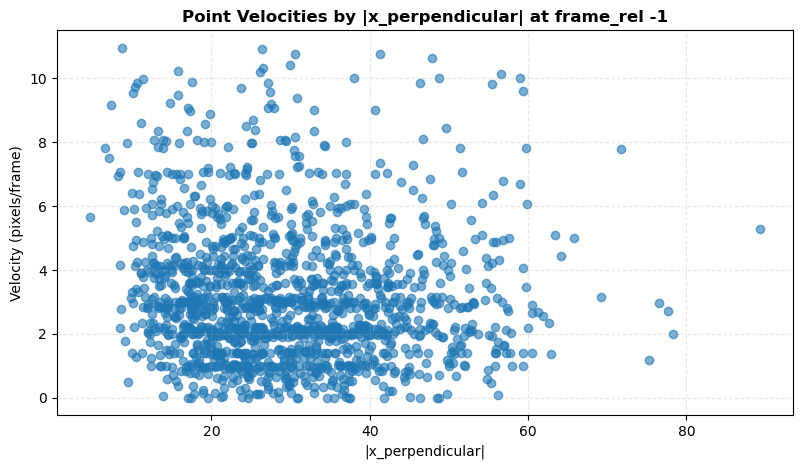

In [165]:
bu.plot_velocities_by_x_perpendicular(points_final, frame_rel=-1)

In [166]:
# Filter for frame_rel == -1
df = points_v_filtered.copy()
subset = df[df['frame_rel'] == -1].dropna(subset=['velocity', 'x_perpendicular'])

# Calculate correlation between velocity and abs(x_perpendicular)
corr = subset['velocity'].corr(subset['x_perpendicular'].abs())
print(f"Correlation between velocity and abs(x_perpendicular) at frame_rel = -1: {corr:.3f}")

# p-value
from scipy.stats import pearsonr
corr_coef, p_value = pearsonr(subset['velocity'], subset['x_perpendicular'].abs())
print(f"P-value for the correlation: {p_value:.3e}")

Correlation between velocity and abs(x_perpendicular) at frame_rel = -1: -0.039
P-value for the correlation: 1.306e-01


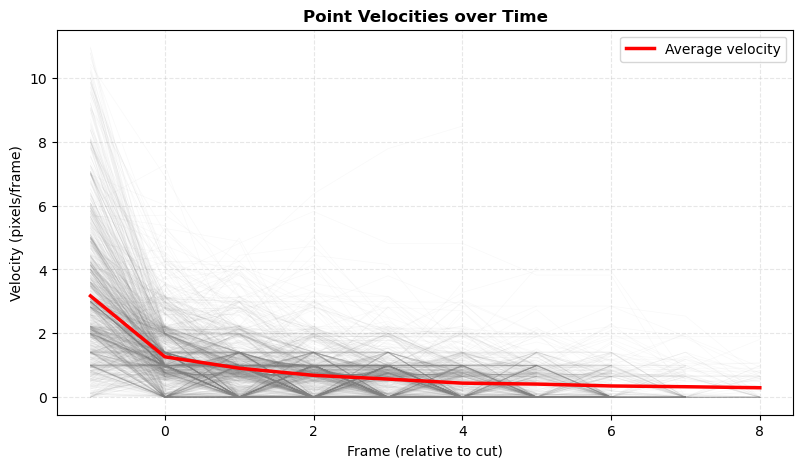

In [167]:
bu.plot_velocities_over_time(points_final)